# EveryBeam OSKAR-"MWA" integration tests

As `WODEN` has been heavily tested with the `MWA` beam, it makes sense to start by trying the replicate an `MWA` beam through `everybeam`. As we're aiming to use `Python` and the `MWA` binding doesn't exist as of yet, we'll use the `OSKAR` beam model to simulate the `MWA` beam. We can do that by creating a measurement set with the `MWA` array layout and the tile configuration, and then just use the `OSKAR` dipole model to do the beam forming. This let's us compare results with known tested `hyperbeam` `MWA_FEE`. Should be good enough to check we have the right sign conventions, and things look sensible on the sky.

To see how the `OSKAR-MWA` measurement set was created, see the `WODEN/test_installation/everybeam/create_OSKAR-MWA_ms/make_oskar-mwa_beam.ipynb` notebook.

Goes without saying, but the test here rely on `everybeam` being installed.

In [1]:
# %load_ext autoreload
# %autoreload 2

from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.use_everybeam import load_OSKAR_telescope, load_LOFAR_telescope, get_everybeam_norm, run_everybeam, radec_to_xyz
import erfa
import mwa_hyperbeam
from wodenpy.skymodel.read_fits_skymodel import calc_everybeam_for_components
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.use_libwoden.skymodel_structs import c_double_complex


##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

Set up some observationals parameters. 

In [2]:
ra0 = 0.0
dec0 = -26.7
MWA_LAT=-26.703319405555554

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=116.67081523611111*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")


LST: 0.00455202630786671 deg, RA: 0.0


## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


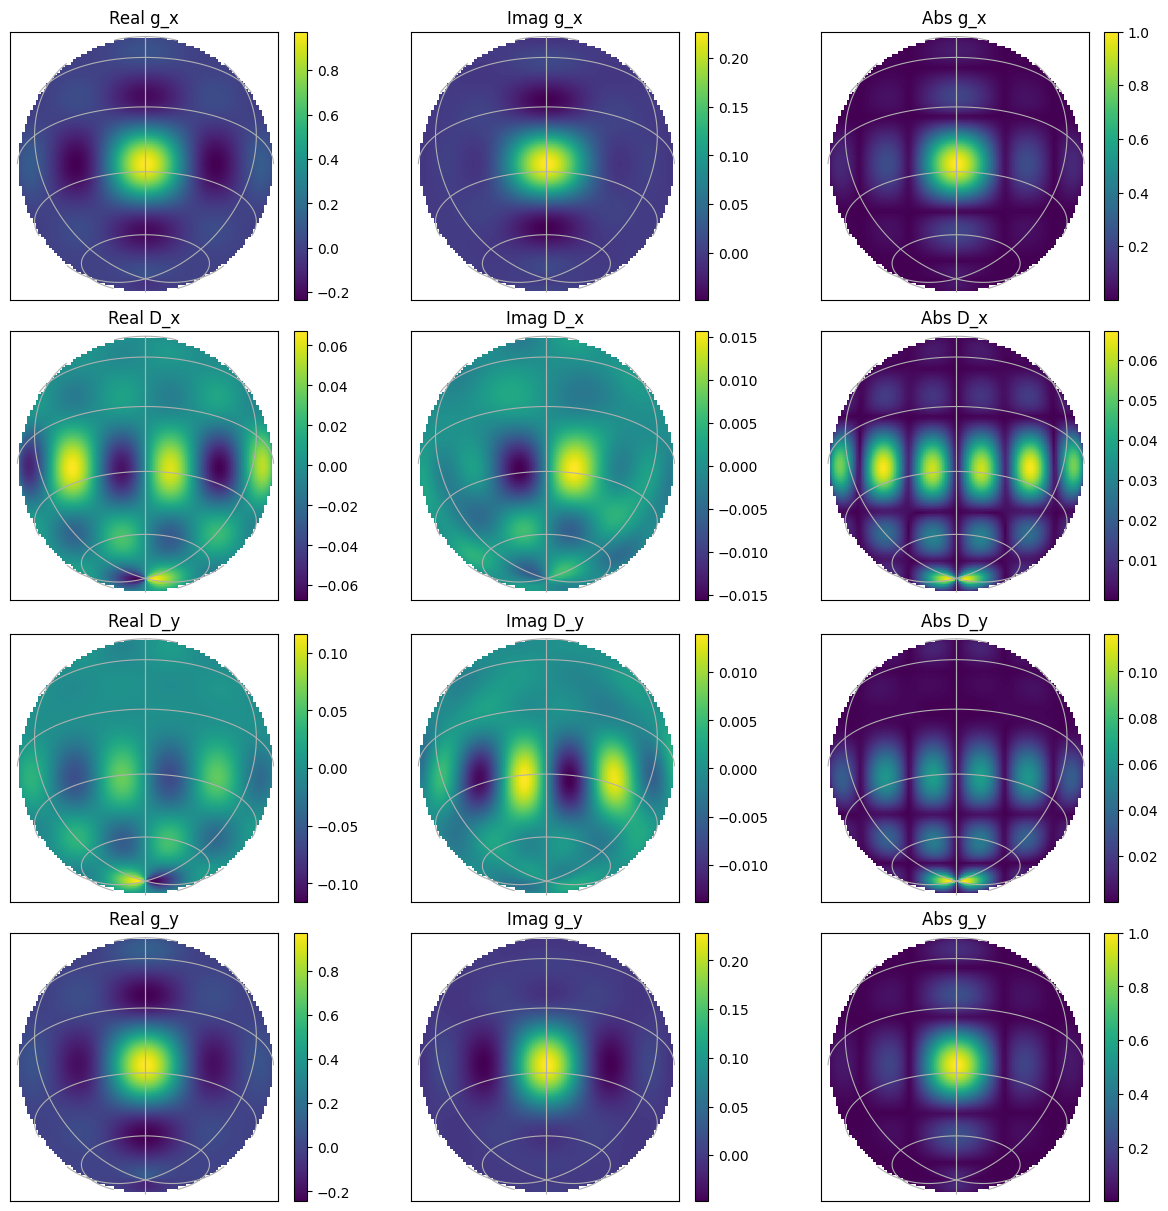

In [3]:
nside=100
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

##Then use erfa to convert these values into azs, els
has = LST_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT))

za_grid = np.pi/2 - els

beam = mwa_hyperbeam.FEEBeam()

freq = 180e+6


jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16, True, np.radians(MWA_LAT), True)


all_gx = jones[:,0]
all_Dx = jones[:,1]
all_Dy = jones[:,2]
all_gy = jones[:,3]

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs)

Next, let's do the equivalent for the `everybeam` `OSKAR` "MWA" beam model and see how it compares

OSKAR response model skala40_wave
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 MHz instead


2024-08-28 03:26:59	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 03:26:59	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 03:26:59	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 03:26:59	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 03:26:59	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 03:26:59	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 03:26:59	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

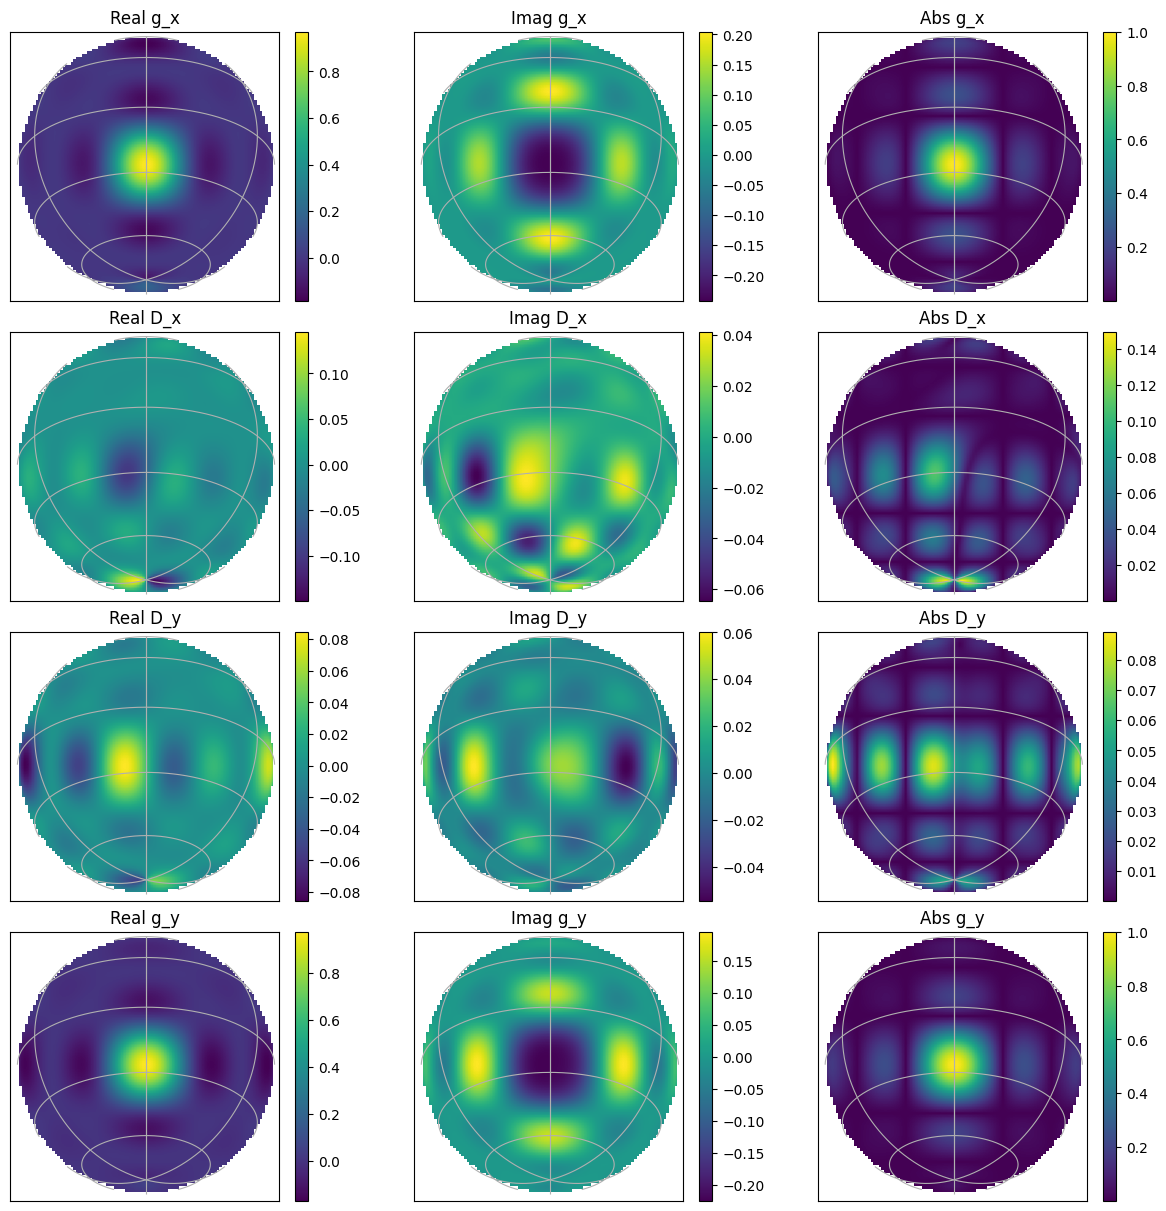

In [4]:
##I made the measurement set using OSKAR with the MWA layout
ms_path="create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms"

# Load the telescope
telescope = load_OSKAR_telescope(ms_path)  
station_id = 0
    
plot_everybeam_on_sky(ra0, dec0, observing_time, 180e6, station_id, telescope)

Soooo there are a couple of differences, but the amplitudes of the X and Y beams are pretty similar which is schweet

## Stokes IQUV recovery

Now test that we can recover Stokes IQUV from a point source.

Make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [78]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [6]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through the MWA FEE beam. We're avoiding using metafits here to be as apples to apples with `EveryBeam` as possible.

In [79]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "MWA_FEE"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]'
    
    call(command, shell=True)

You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 minsWODEN is using DOUBLE precision

Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have c

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [80]:

for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)
    


Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


### Do it with `OSKAR` "MWA" `everybeam`

Right, try and do the same thing with `OSKAR` "MWA" `everybeam`

In [81]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_OSKAR"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f' --station_id=0 ' ##default behaviour is to use a different primary beam for each station. All stations are the same here so pick first one.
    command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms'
    
    call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 M

2024-08-28 04:42:25	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 04:42:25	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 04:42:25	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 04:42:25	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 04:42:25	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 04:42:25	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 04:42:25	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 193 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 194 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 195 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 196 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 201 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 202 MHz, using the nearest 

2024-08-28 04:42:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 04:42:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 04:42:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 04:42:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 04:42:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 04:42:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 04:42:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 190 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 191 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 192 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 193 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 194 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 195 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 196 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest 

2024-08-28 04:42:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 04:42:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 04:42:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 04:42:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 04:42:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 04:42:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 04:42:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 190 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 191 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 192 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 193 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 194 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 195 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 196 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest 

2024-08-28 04:42:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 04:42:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 04:42:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 04:42:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 04:42:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 04:42:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 04:42:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 197 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 198 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 199 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 200 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 201 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 202 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 203 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 204 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 205 MHz, using the nearest neighbor with frequency 230 MHz instead
Could not load dataset for frequency 206 MHz, using the nearest 

In [82]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'everybeam_OSKAR', atol=9e-2)
    
    ##Uncomment to print out example values
    
    uvfits_name = f"stokes{pol}_everybeam_OSKAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    ##pick a random baseline to plot, they should all be the sam
    baseline = 0

    recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
I, 1.00, 0.00, -0.04, -0.04
Testing Stokes Q
Stokes Q passed
Q, -0.00, 1.00, 0.08, -0.06
Testing Stokes U
Stokes U passed
U, -0.04, -0.08, 1.00, -0.02
Testing Stokes V
Stokes V passed
V, -0.04, 0.05, 0.02, 1.00


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [83]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN.

In [84]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} --array_layout={array_name} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]'

call(command, shell=True)

You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have c

0

Have a look and check our visis make sense

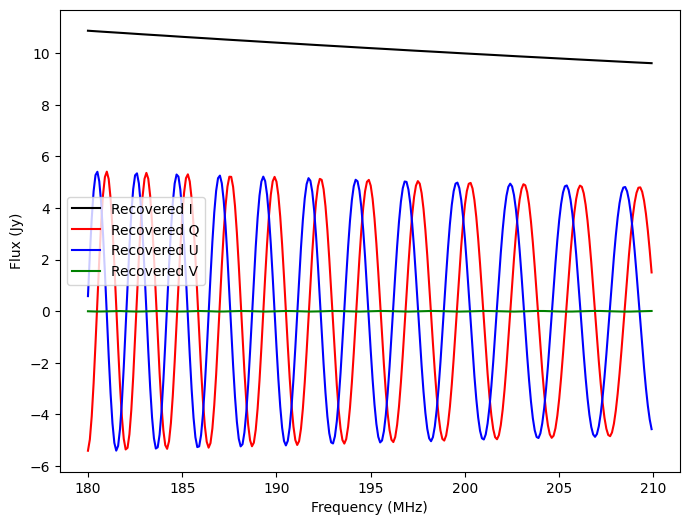

In [85]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Now define a test, using a bunch of Emil's RM synthesis code. 

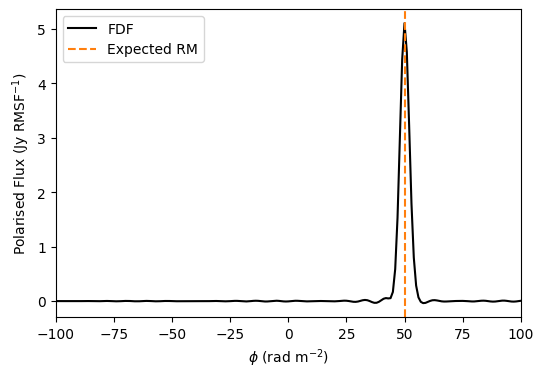

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999532 Expected Pol Fraction 0.5


In [86]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

### Do it with `everybeam`

In [87]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_OSKAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 M

2024-08-28 04:42:54	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 04:42:54	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 04:42:54	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 04:42:54	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 04:42:54	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 04:42:54	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 04:42:54	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest neighbor with frequency 160 MHz instead
Could not load dataset for frequency 182 MHz, using the nearest 

0

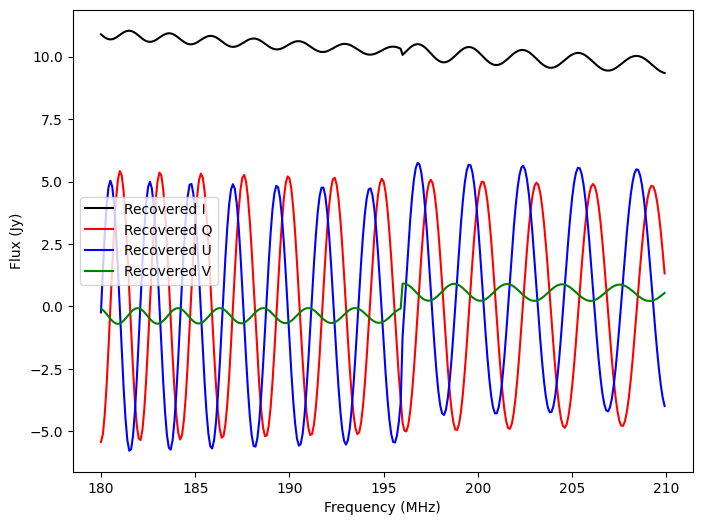

In [88]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_OSKAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Hmmm so the step change at about ~195MHz is because the OSKAR beam model is only stored at 160 and 230MHz. And then the horrific wobble in Stokes I must be because of leakage out Stokes Q/U. That's pretty scary, but I have no idea exactly what the `skala40` beam model really is.

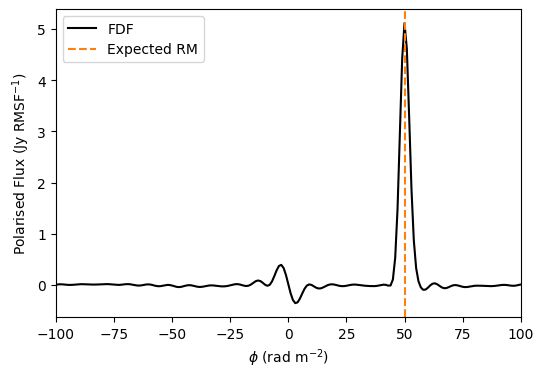

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.5003593 Expected Pol Fraction 0.5


In [17]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs, atol=0.11)

So we still manage to recover the RM, but you can definitely see the instrumental leakage at RM=0.

## Test antenna locations

Now check to see if the antenna locations are read in correctly from a measurement set. We'll run `WODEN` using the `metafits` file that was used to make the `OSKAR MWA` measurement set. Then compare that to running the with the same settings but using the `OSKAR MWA` measurement set directly. 

In [18]:
freq_reso = 0.1e+6
low_freq = 180e+6
num_freq_chans = 1

primary_beam = "MWA_FEE"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--metafits_filename=../../examples/metafits/1126115208_metafits.fits '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += '--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] '


call(command, shell=True)


You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have c

0

In [19]:
primary_beam = "everybeam_OSKAR"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave
Could not load dataset for frequency 180 MHz, using the nearest neighbor with frequency 160 M

2024-08-28 03:27:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 03:27:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 03:27:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 03:27:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 03:27:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 03:27:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 03:27:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


0

Read in the XYZ positions from the resultant `uvfits` files, as well as the `uvw` coordinates.

In [20]:
def read_xyz_uvfits(uvfits_name):
    
    with fits.open(uvfits_name) as hdu:
        xyz = hdu[1].data['STABXYZ']
        uu = hdu[0].data['UU']*C
        vv = hdu[0].data['VV']*C
        ww = hdu[0].data['WW']*C
        
    return xyz, uu, vv, ww


In [21]:
xyz_meta, uu_meta, vv_meta, ww_meta = read_xyz_uvfits('ant_locs_MWA_FEE_band01.uvfits')
xyz_ms, uu_ms, vv_ms, ww_ms = read_xyz_uvfits('ant_locs_everybeam_OSKAR_band01.uvfits')

First up compare the XYZ coords

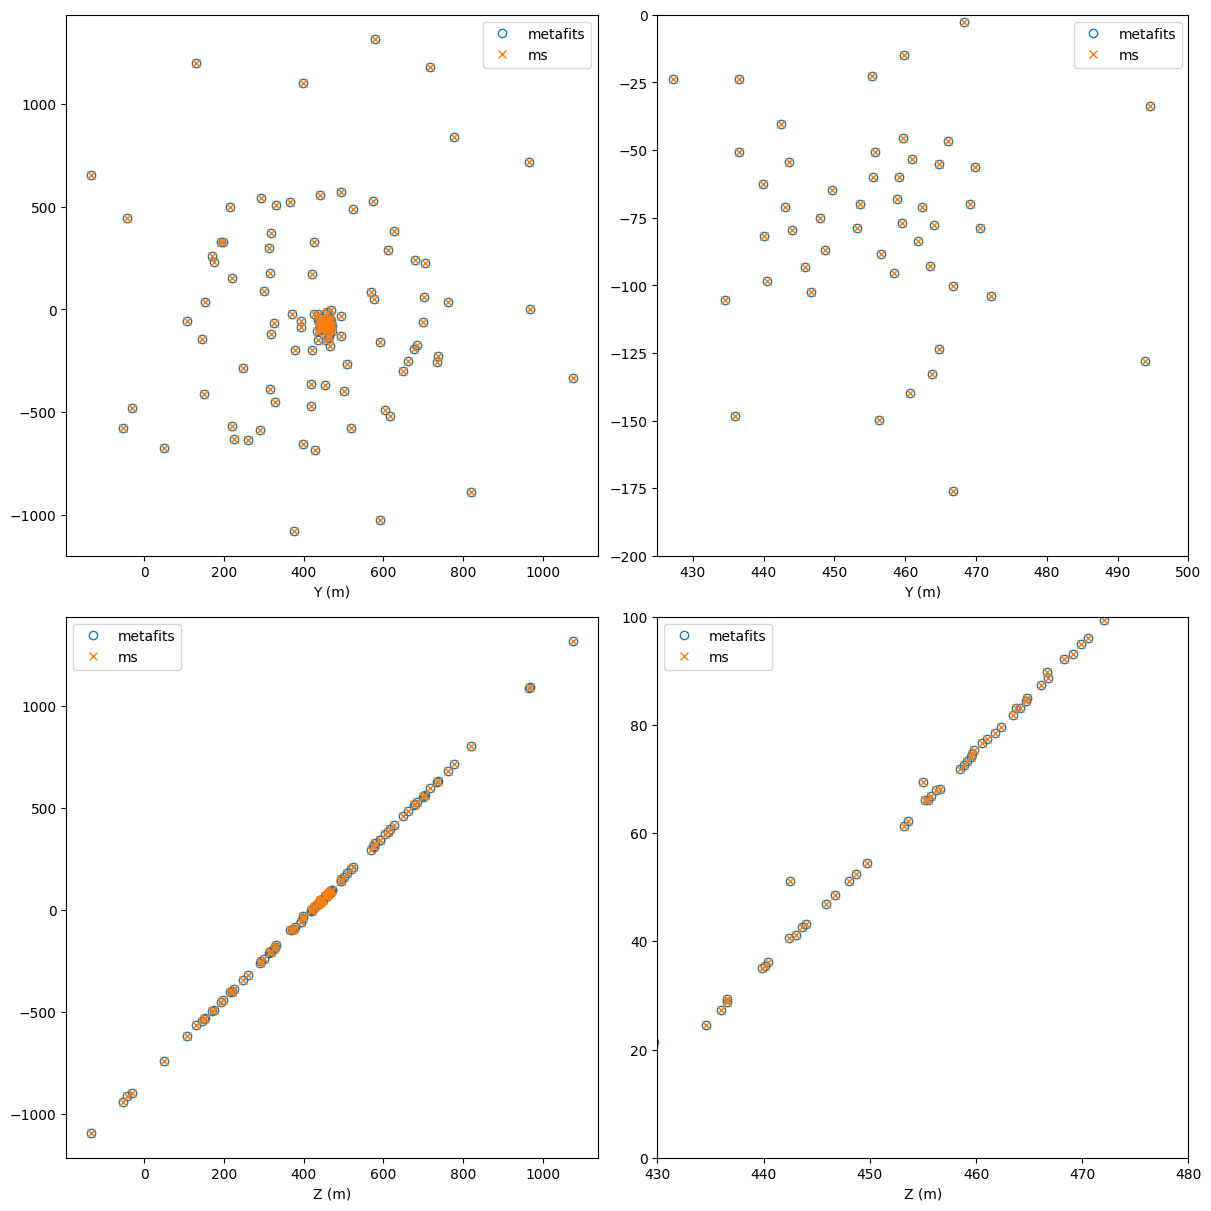

In [22]:
def plot(xyz, ax1, ax2, marker, label):
        
        ax1.plot(xyz[:,0], xyz[:,1], marker, mfc='none', label=label)
        ax2.plot(xyz[:,0], xyz[:,2], marker, mfc='none', label=label)
        
        
fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

plot(xyz_meta, axs[0,0], axs[1,0], 'o', 'metafits')
plot(xyz_ms, axs[0,0], axs[1,0], 'x', 'ms')

plot(xyz_meta, axs[0,1], axs[1,1], 'o', 'metafits')
plot(xyz_ms, axs[0,1], axs[1,1], 'x', 'ms')

axs[0,1].set_xlim(425, 500)
axs[0,1].set_ylim(-200, 0)

axs[1,1].set_xlim(430, 480)
axs[1,1].set_ylim(0, 100)

for ax in axs.flatten():
    ax.legend()
    
axs[0,0].set_xlabel('X (m)')
axs[0,0].set_xlabel('Y (m)')
axs[0,1].set_xlabel('X (m)')
axs[0,1].set_xlabel('Y (m)')

axs[1,0].set_xlabel('X (m)')
axs[1,0].set_xlabel('Z (m)')
axs[1,1].set_xlabel('X (m)')
axs[1,1].set_xlabel('Z (m)')

plt.show()

In [23]:
np.allclose(xyz_meta, xyz_ms, atol=1e-3, rtol=1e-6)


True

Now compare the `uv` coords. 

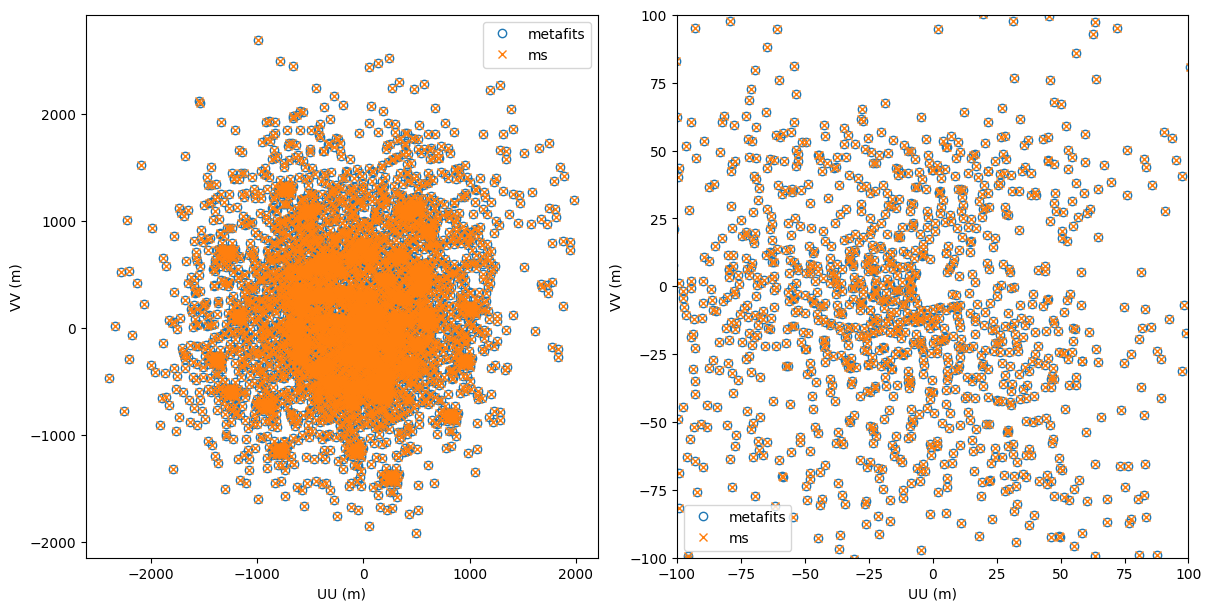

In [24]:
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')


for ax in axs:

    ax.plot(uu_meta, vv_meta, 'C0o', mfc='none', label='metafits')
    # ax.plot(-uu_meta, -vv_meta, 'C0o', mfc='none')

    ax.plot(uu_ms, vv_ms, 'C1x', mfc='none', label='ms')
    # ax.plot(-uu_ms, -vv_ms, 'C1x', mfc='none')
    
    ax.set_xlabel('UU (m)')
    ax.set_ylabel('VV (m)')
    
    ax.legend()
        
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(-100, 100)

plt.show()

In [25]:
print(f"u coords max, mean diff {np.max(np.abs(uu_meta - uu_ms)):.2e}, {np.mean(np.abs(uu_meta - uu_ms)):.2e} (metres)")
print(f"v coords max, mean diff {np.max(np.abs(vv_meta - vv_ms)):.2e}, {np.mean(np.abs(vv_meta - vv_ms)):.2e} (metres)")
print(f"w coords max, mean diff {np.max(np.abs(ww_meta - ww_ms)):.2e}, {np.mean(np.abs(ww_meta - ww_ms)):.2e} (metres)")

u coords max, mean diff 7.45e-09, 9.17e-13 (metres)
v coords max, mean diff 0.00e+00, 0.00e+00 (metres)
w coords max, mean diff 9.54e-07, 2.69e-10 (metres)


## Let's see if we can make flagged dipole beams

Again, I've used `OSKAR` to make a measurement set via `make_oskar-mwa_beam.ipynb`. This time I've made the first 16 tiles have a flagged dipole each; this should give us visible beam shape deformities. First plot them on the sky to check we are getting the right thing. Then we'll look inside the visibilities for a single off-zenith point source as different beams means the amplitudes of the visis should vary.

In [42]:
##Setup a grid of RA/Dec on the sky
nside=80
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

##Create a woden struct class with double precision for the components
struct_classes = Woden_Struct_Classes(precision='double')

##Create the components struct
components = struct_classes.Components()
##Allocate memory for the coords
components.ras = (c_double*num_comps)()
components.decs = (c_double*num_comps)()

##populate the coords
for ind, ra, dec in zip(range(num_comps), ras, decs):
    components.ras[ind] = ra
    components.decs[ind] = dec

# # Load the telescope
telescope = load_OSKAR_telescope("create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms")
num_beams = telescope.nr_stations

##Do a couple of frequencies to check mapping is working
all_freqs = np.array([160e+6, 230e+6])
# all_freqs = np.array([200e+6])

##Do two times, 3 hours apart to check things move on the sky
all_times = np.array([observing_time, observing_time + TimeDelta(3*3600, format='sec')])
# all_times = np.array([observing_time])

##allocate memory for the beam values

num_freqs = len(all_freqs)
num_times = len(all_times)

complex_num_beams = c_double_complex*(num_comps*num_beams*num_freqs*num_times)
        
components.gxs = complex_num_beams()
components.Dxs = complex_num_beams()
components.Dys = complex_num_beams()
components.gys = complex_num_beams()

OSKAR response model skala40_wave


In [43]:
calc_everybeam_for_components(np.radians(ra0), np.radians(dec0),
                              num_comps, components, telescope,
                              all_times, all_freqs)

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)


In [44]:

##grab the outputs, which should be ordered as primary beam slowest changing, time, freq, componnent fastest changing
##Do it over loops so we can get the real/imag parts out of the c_double_complex struct
recover_gx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)

for beam_ind in range(num_beams):
    for time_ind, time in enumerate(all_times):
        for freq_ind, freq in enumerate(all_freqs):
            for comp_ind in range(num_comps):
                recover_gx[beam_ind, time_ind, freq_ind, comp_ind] = components.gxs[beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind].real + 1j*components.gxs[beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind].imag

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


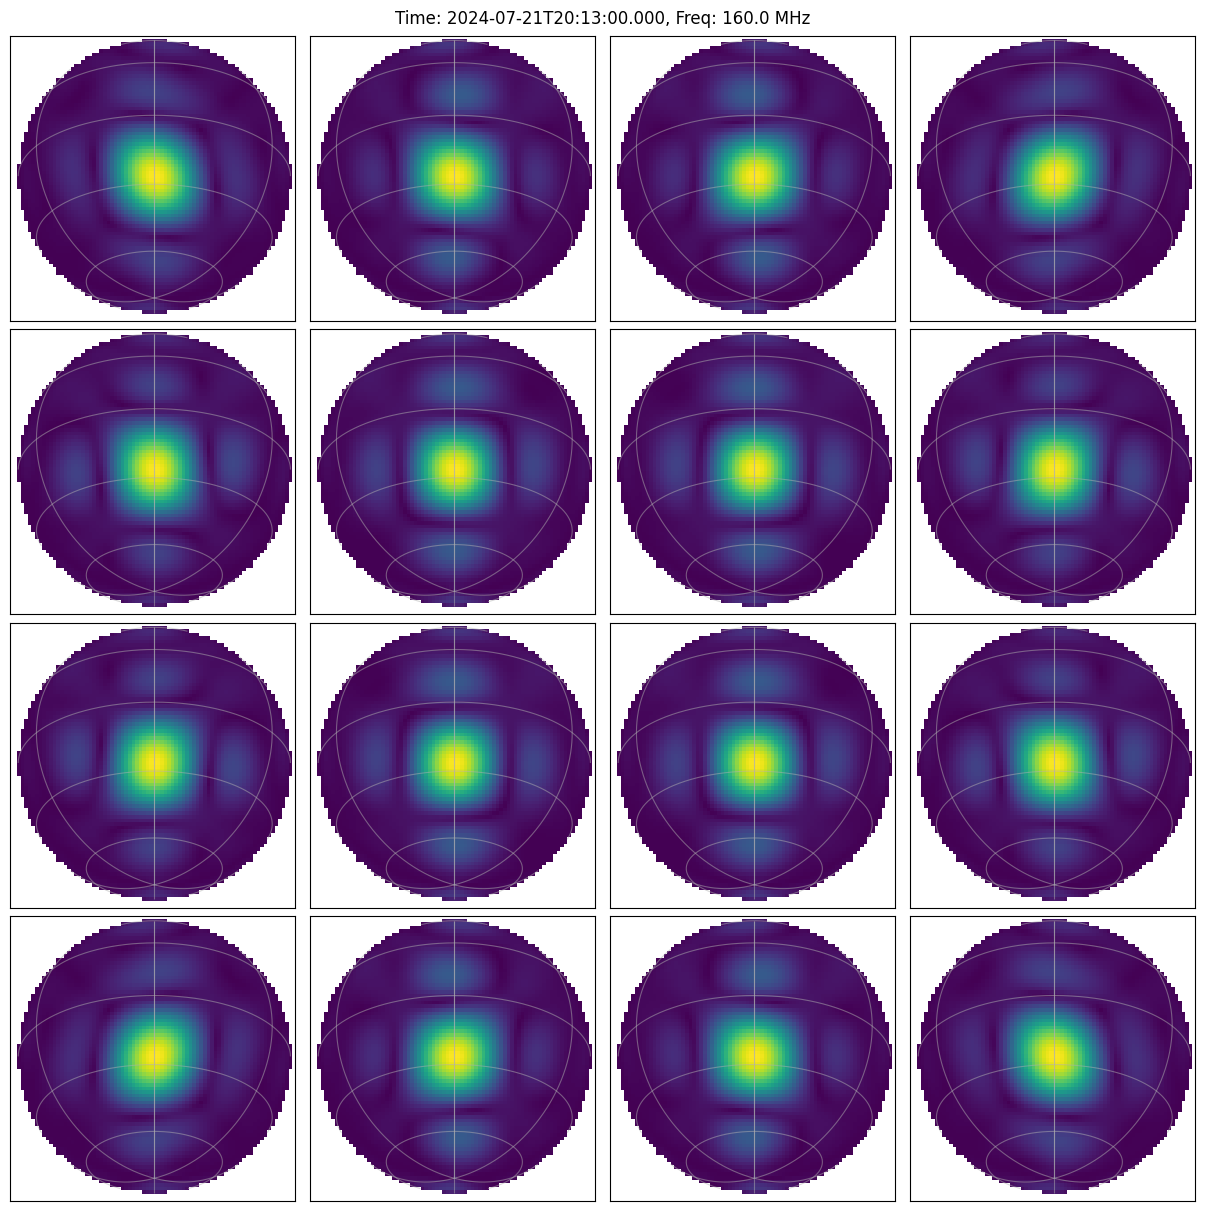

In [57]:
lsts = [time.sidereal_time('mean').value*15 for time in all_times]
ra_mesh = ras.reshape(nside, nside)
dec_mesh = decs.reshape(nside, nside)

def plot_beam_selection(recover_gx, time_ind, freq_ind, nside, wcs):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12), layout='constrained',
                            subplot_kw={'projection': wcs})
    
    
    az_grid, els = erfa.hd2ae(np.radians(lsts[time_ind]) - ra_mesh, dec_mesh, np.radians(MWA_LAT))
    
    mask = np.ones_like(az_grid)
    mask[els < 0] = np.nan
    
    for col in range(4):
        for row in range(4):
            beam_ind = col*4 + row
            
            gx = recover_gx[beam_ind, time_ind, freq_ind, :]
            gx.shape = (nside, nside)
            
            axs[row, col].imshow(np.abs(gx)*mask, origin='lower')
            
            axs[row, col].grid(alpha=0.5)
            
            lon = axs[row, col].coords[0]
            lat = axs[row, col].coords[1]
            
            lon.set_ticks_visible(False)
            lat.set_ticks_visible(False)
            lon.set_axislabel(' ')
            lat.set_axislabel(' ')
            
            
            if col > 0:
                lat.set_ticklabel_visible(False)
            if row < 3:
                lon.set_ticklabel_visible(False)
            

    fig.suptitle(f"Time: {all_times[time_ind].isot}, Freq: {all_freqs[freq_ind]/1e+6} MHz")

    plt.show()
    
plot_beam_selection(recover_gx, 0, 0, nside, wcs)

Great success, we can see our beams are deformed in different ways for the first 16 dipoles. Let's try a different frequency:

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


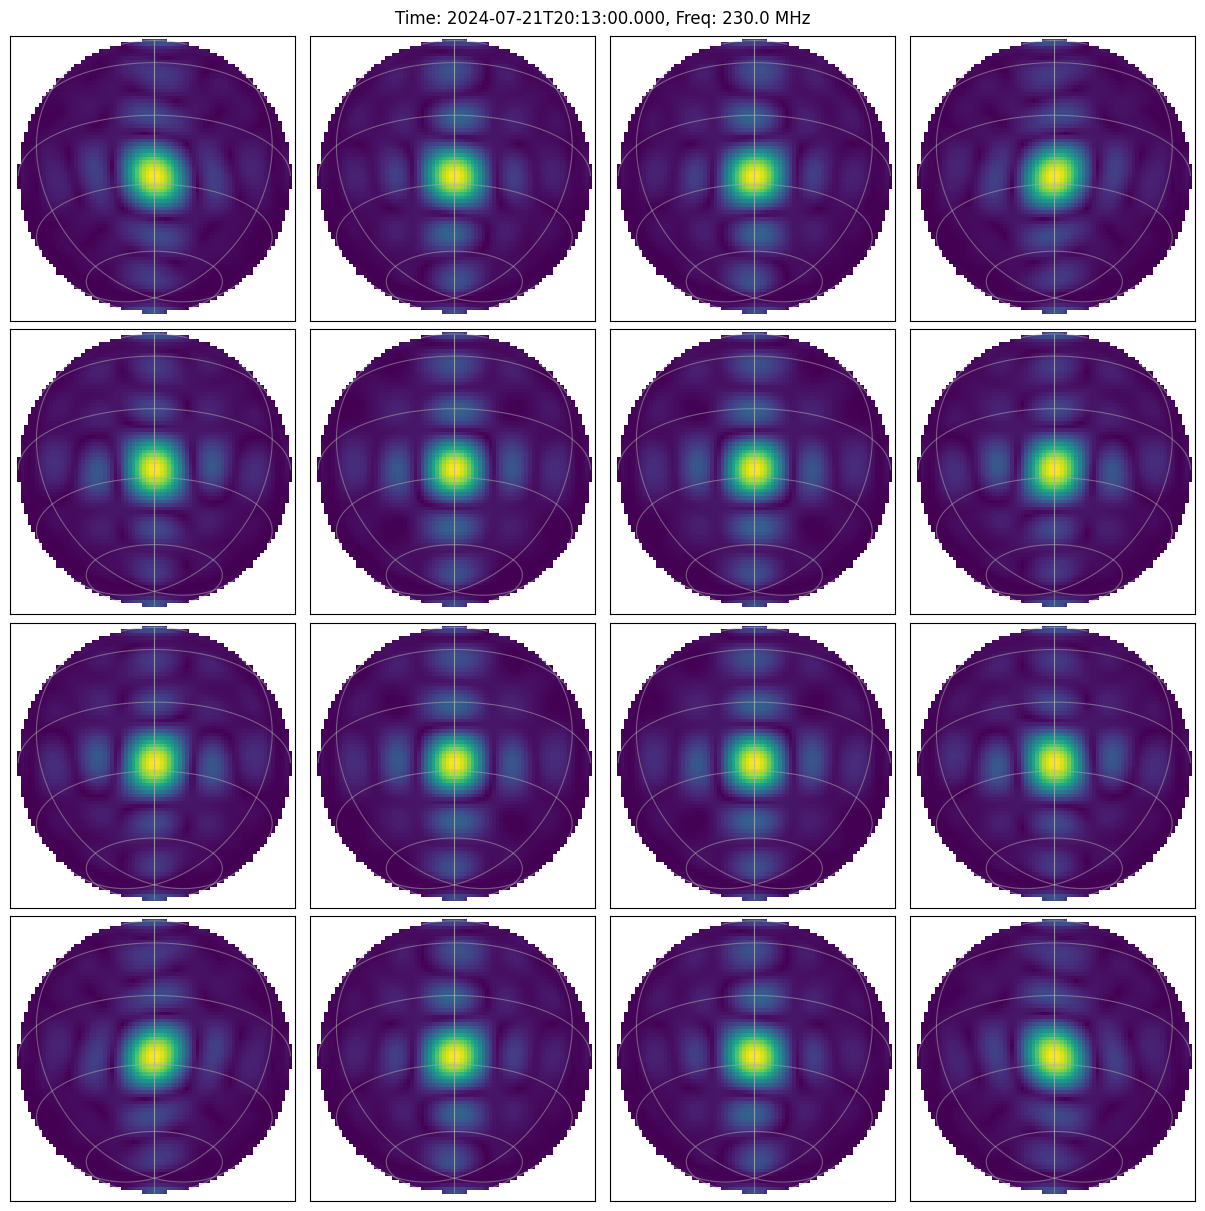

In [58]:
plot_beam_selection(recover_gx, 0, 1, nside, wcs)

Now we'll try 3 hours later in time:

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


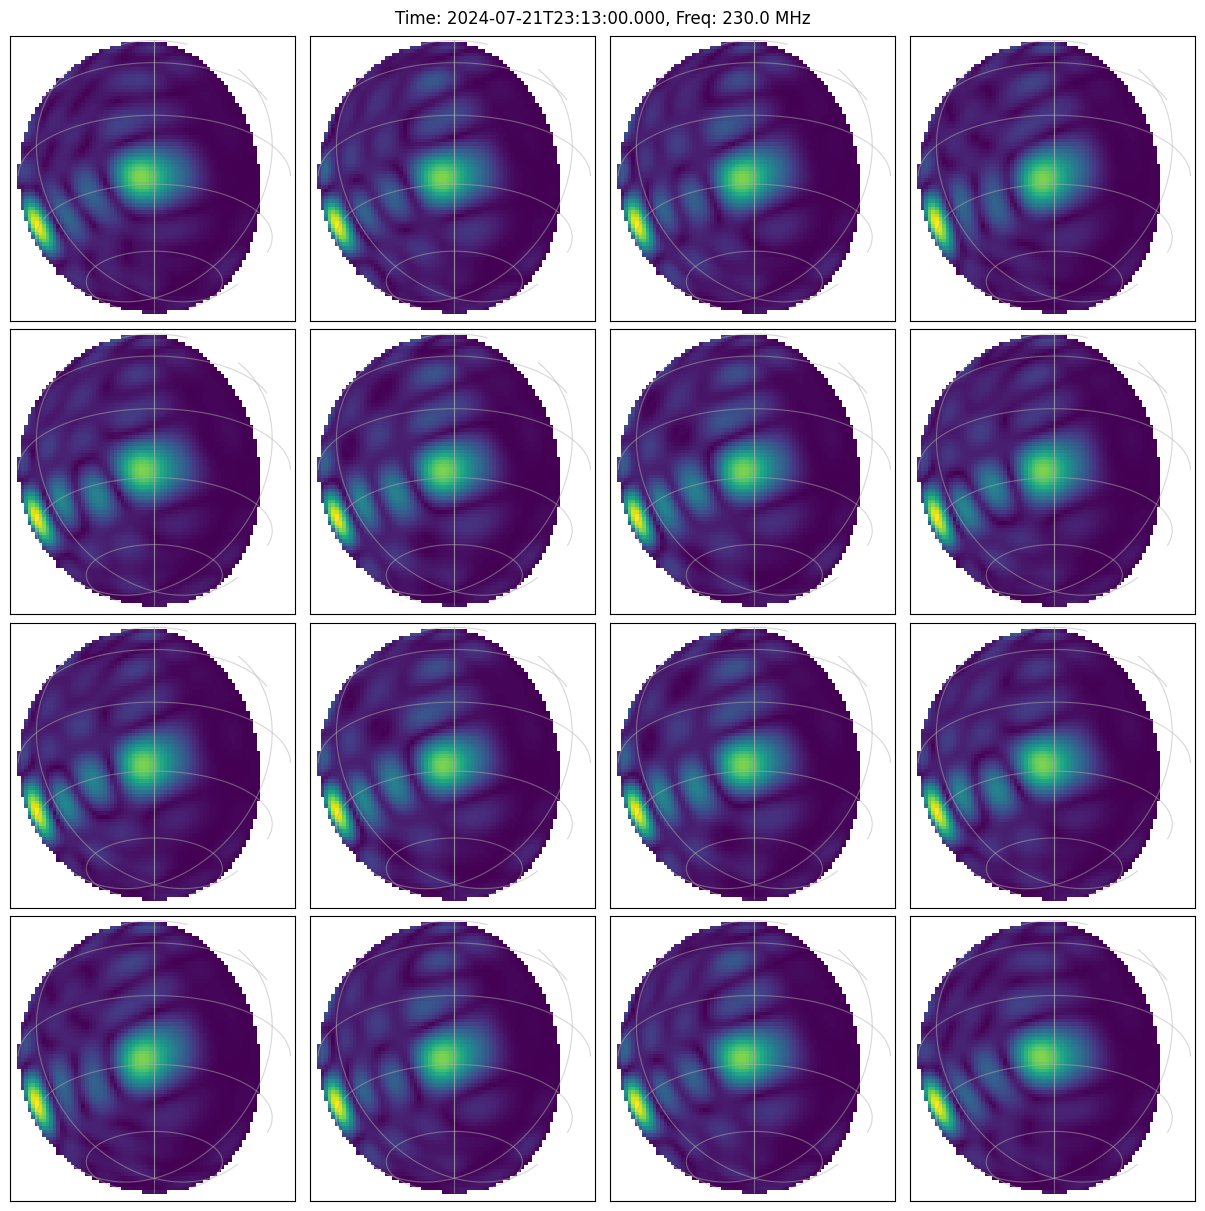

In [59]:
plot_beam_selection(recover_gx, 1, 1, nside, wcs)

OK, this looks really weird with the beam maximum not being at phase centre. But we can get the same thing using `hyperbeam`; it's just a phased array MWA thing.

In [76]:
##Then use erfa to convert these values into azs, els
has = np.radians(lsts[1]) - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, np.radians(MWA_LAT))

za_grid = np.pi/2 - els

beam = mwa_hyperbeam.FEEBeam()

freq = 230e+6

delays = [4, 8, 12, 16]*4

jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), True)

/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


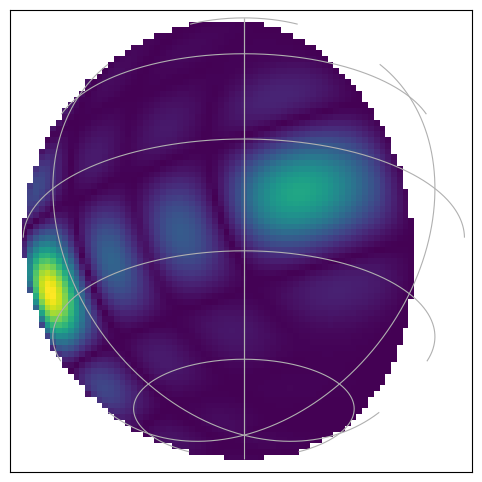

In [77]:
all_gx = jones[:,0]

all_gx = np.abs(all_gx).reshape(nside, nside)

mask = np.ones((nside, nside))
mask[els.reshape(nside, nside) < 0] = np.nan 

fig, axs = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': wcs})

axs.grid()

axs.imshow(all_gx*mask, origin='lower')

plt.show()

Now let's check the visibilities. First of all, we'll check all the visis are the same when we use the same primary beam for all tiles. Then we'll play with the flagged tiles to see what happens

In [32]:

##make some more single point source sky models, but this time for an offzenith source
make_sky_models(ra0 + 15, dec0)

In [33]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 70e+6
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "everybeam_OSKAR"

uvfits_name = f"noflag_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--station_id=20 '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 wi

2024-08-28 03:45:38	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 03:45:38	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 03:45:38	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 03:45:38	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 03:45:38	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 03:45:38	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 03:45:38	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


0

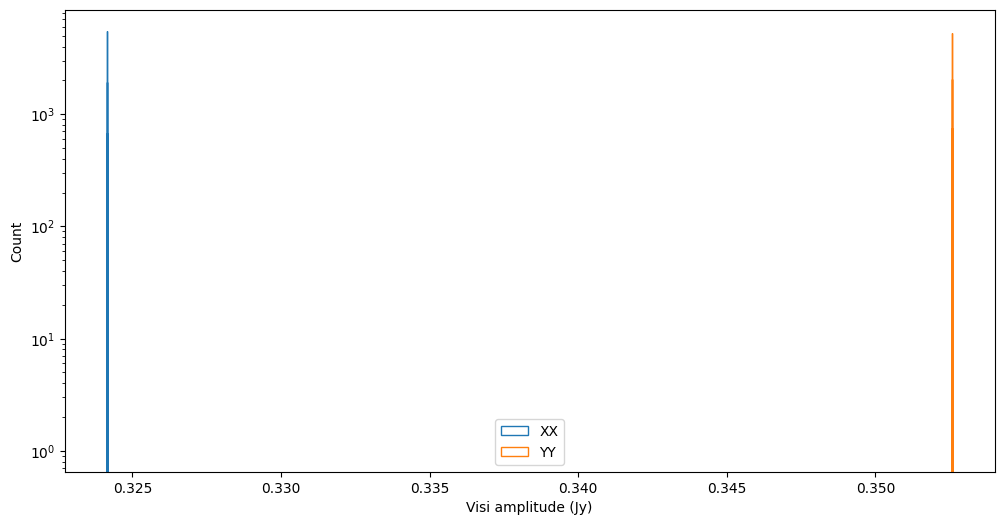

In [34]:
XX, XY, YX, YY = read_uvfits('noflag_everybeam_OSKAR_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=100, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=100, histtype='step', color='C1', label='YY')

xx_noflag_osk = np.mean(np.abs(XX[:, 0]))
yy_noflag_osk = np.mean(np.abs(YY[:, 0]))

axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()


In [35]:
unchanged = 0
num_ants = 128

num_baseline = 0

first_unchanged = np.nan


for i in range(num_ants - 1):
    for j in range(i+1, num_ants):
        if i > 15 and j > 15:
            
            if np.isnan(first_unchanged):
                first_unchanged = num_baseline
            
            unchanged += 1
        num_baseline += 1
    
print(f"Percentage of expected unchanged baselines: {unchanged} / {num_baseline} = {unchanged/num_baseline*100:.2f}%")
print(f"First unchanged baseline: {first_unchanged}")

Percentage of expected unchanged baselines: 6216 / 8128 = 76.48%
First unchanged baseline: 1912


In [36]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 70e+6
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "everybeam_OSKAR"

uvfits_name = f"flagged_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--beam_ms_path=create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-MWA_ms/OSKAR-MWA-flags-layout.ms/ANTENNA: 8 columns, 128 rows
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave


2024-08-28 03:45:40	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-28 03:45:40	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-28 03:45:40	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-28 03:45:40	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-28 03:45:40	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-28 03:45:40	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-28 03:45:40	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.60000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


0

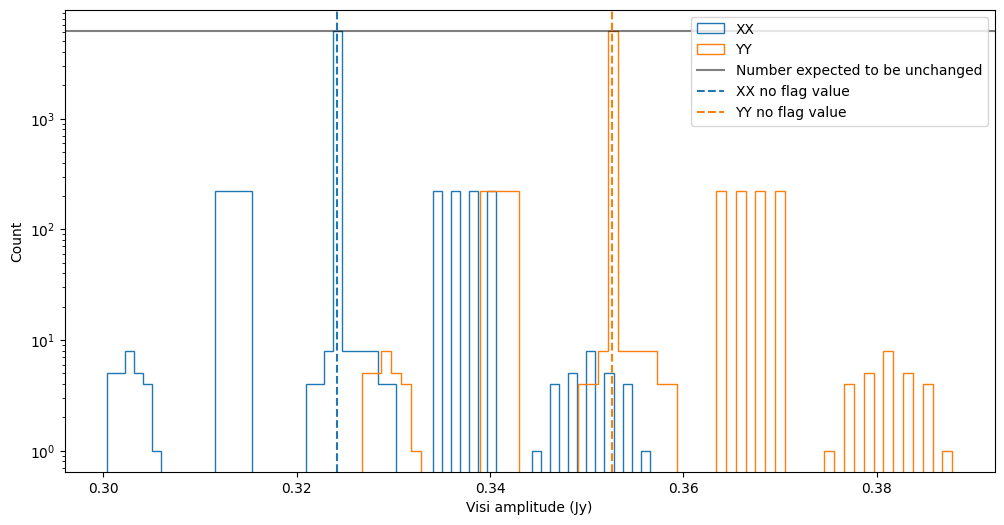

In [37]:
XX, XY, YX, YY = read_uvfits('flagged_everybeam_OSKAR_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=60, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=60, histtype='step', color='C1', label='YY')

axs.axhline(unchanged, color='k', linestyle='-', alpha=0.5, label='Number expected to be unchanged')


axs.axvline(xx_noflag_osk, color='C0', linestyle='--', label='XX no flag value')
axs.axvline(yy_noflag_osk, color='C1', linestyle='--', label='YY no flag value')


axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

OK, this makes sense. I only put dipole flags on the first 16 tiles, so a large number of the visibilities should have the same value (which are the big central peaks of each distribution). The XX and YY are different amplitudes, as I put the source on the meridian. This means the XX and YY beams should have different sensitivities. They both have the same dipole flags however, so the distributions should have a similar shape as they do.

Maybe counter-intuitive, but with the change in beam shape per tiles, some beams can become relatively more sensitive than others. As I'm normalising each beam individually towards the phase centre, this means we can high a higher ampltiude than the full 16 dipole beam. This behaviour probably needs to be changed to have some kind of overall normalisation, but this is a good first step.

Let's compare that to a `hyperbeam` model with the same flags



In [38]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 70e+6
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "MWA_FEE"

uvfits_name = f"noflags_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--metafits=create_OSKAR-MWA_ms/1088285600_flags.metafits '
# command += f'--use_MWA_dipamps'

call(command, shell=True)

You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.60000000e+08
Middle freq is 1.60640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have c

0

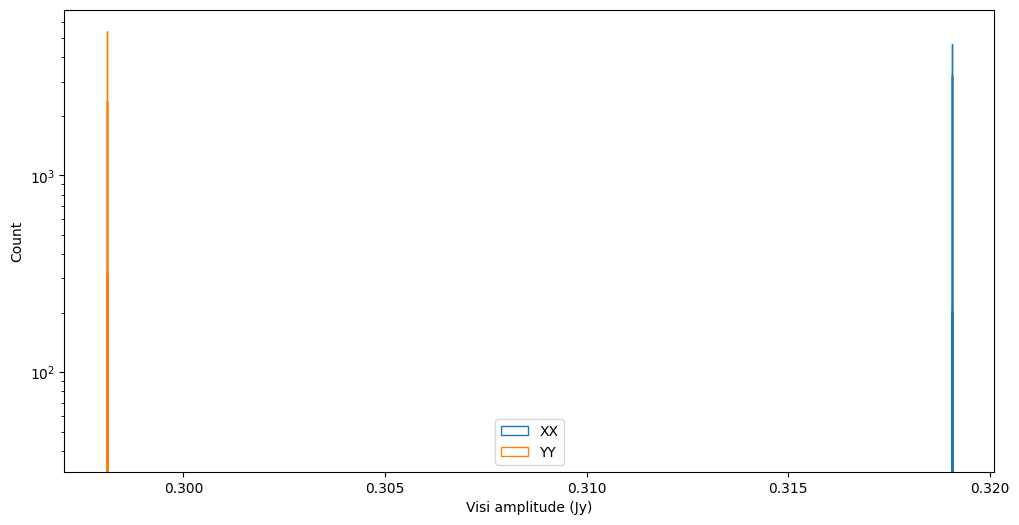

In [39]:
XX, XY, YX, YY = read_uvfits('noflags_MWA_FEE_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=100, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=100, histtype='step', color='C1', label='YY')

xx_noflag = np.mean(np.abs(XX[:, 0]))
yy_noflag = np.mean(np.abs(YY[:, 0]))

axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()



In [40]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 70e+6
low_freq = 160e+6
num_freq_chans = 2

primary_beam = "MWA_FEE"

uvfits_name = f"flagged_{primary_beam}"
cat_name = 'I_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--metafits=create_OSKAR-MWA_ms/1088285600_flags.metafits '
command += f'--use_MWA_dipflags'

call(command, shell=True)

Num tiles with dipole flags: 16
You are using WODEN commit: 72aad54
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 minsWODEN is using DOUBLE precision

Simulating band 01 with bottom freq 1.60000000e+08
Middle freq is 1.60640000e+08 
About to copy the chunked source to the GPU
Have copied across th

0

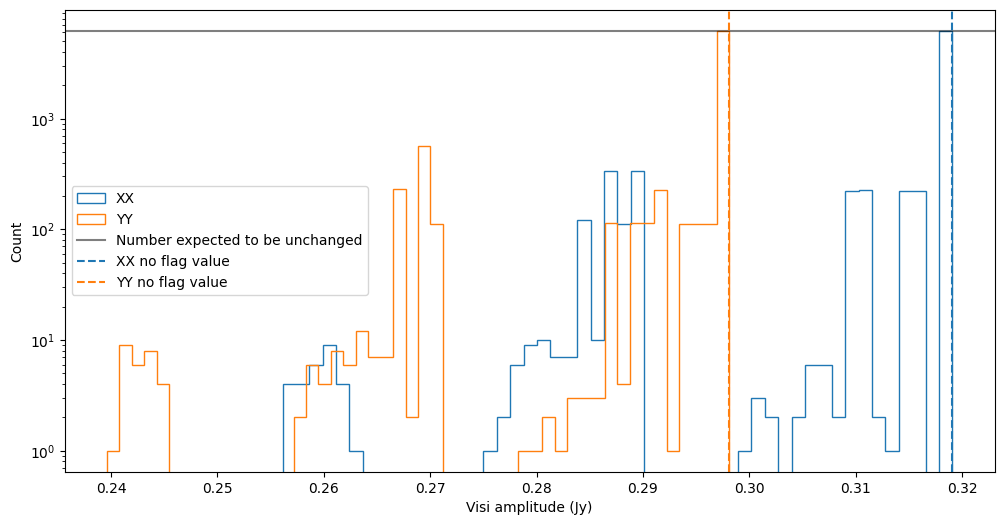

In [41]:
XX, XY, YX, YY = read_uvfits('flagged_MWA_FEE_band01.uvfits')

##take the XX and YY for the first freq and do some histograms


fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.hist(np.abs(XX[:, 0]), bins=50, histtype='step', color='C0', label='XX')
axs.hist(np.abs(YY[:, 0]), bins=50, histtype='step', color='C1', label='YY')

axs.axhline(unchanged, color='k', linestyle='-', alpha=0.5, label='Number expected to be unchanged')


axs.axvline(xx_noflag, color='C0', linestyle='--', label='XX no flag value')
axs.axvline(yy_noflag, color='C1', linestyle='--', label='YY no flag value')


axs.set_xlabel('Visi amplitude (Jy)')
axs.set_ylabel('Count')

axs.set_yscale('log')

axs.legend()

plt.show()

So a similar result to the `everybeam` experiment, with two important differences. Firstly, the `hyperbeam` model is normalised to the full 16 dipole beam, so any dipole flag causes a drop in sensitivity. Hence all visibilities are wither unchanged, or lower than full 16 dipole beam. Secondly, the `XX` and `YY` amps have a slightly different shape. Maybe this has something to do with the different models having different mutual coupling effects, as well as the SKA beam is a christmas tree whereas the MWA dipole is a bowtie.